**Import Libraries Needed **

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.metrics import top_k_categorical_accuracy
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.utils import load_img
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay




In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))


import os
labels = []
image_path = []
for dirname, _, filenames in os.walk('/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/train'):
    for filename in filenames:
        if filename.endswith('.jpg'):
            image_path.append(os.path.join(dirname, filename))
            labels.append(os.path.basename(os.path.normpath(dirname)))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
# Train Test Split
images_train, images_test, labels_train, labels_test = train_test_split(image_path, labels, test_size=0.25, random_state=10, stratify=labels)

In [4]:
model = ResNet50(include_top=False, input_shape=(200,200,3), weights = "/kaggle/input/resnet-weights/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5")

## defining early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

for layer in model.layers:
    layer.trainable = False

#add new classifier layers 

flat1 = Flatten()(model.output)
class1 = Dense(1024, activation = 'relu')(flat1)
drop_layer = Dropout(0.2)(class1)
output = Dense(196, activation = 'softmax')(drop_layer)
model = Model(inputs = model.inputs, outputs = output)

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics = ['accuracy'])

In [5]:
#model.summary()

In [6]:
## Attempting Data Augmentation

data_generator = ImageDataGenerator(preprocessing_function=preprocess_input, horizontal_flip=True, width_shift_range=0.1, height_shift_range=0.1)

#preprocessing
train_folder="../input/stanford-car-dataset-by-classes-folder/car_data/car_data/train"
test_folder="../input/stanford-car-dataset-by-classes-folder/car_data/car_data/test"

#grabbing different images
train_generator = data_generator.flow_from_directory(train_folder, target_size=(200, 200), class_mode='categorical')
test_generator = data_generator.flow_from_directory(test_folder, target_size=(200, 200), class_mode='categorical')

history=model.fit(train_generator, steps_per_epoch=50, validation_data=test_generator, validation_steps=1, epochs=100, callbacks=[early_stop])


Found 8144 images belonging to 196 classes.
Found 8041 images belonging to 196 classes.
Epoch 1/100
50/50 [==============================] - 181s 4s/step - loss: 8.3200 - accuracy: 0.0056 - val_loss: 5.2811 - val_accuracy: 0.0000e+00
Epoch 2/100
50/50 [==============================] - 170s 3s/step - loss: 5.2612 - accuracy: 0.0114 - val_loss: 5.2146 - val_accuracy: 0.0000e+00
Epoch 3/100
50/50 [==============================] - 173s 3s/step - loss: 5.2008 - accuracy: 0.0169 - val_loss: 5.0462 - val_accuracy: 0.0312
Epoch 4/100
50/50 [==============================] - 171s 3s/step - loss: 5.1081 - accuracy: 0.0237 - val_loss: 5.1551 - val_accuracy: 0.0000e+00
Epoch 5/100
50/50 [==============================] - 170s 3s/step - loss: 4.9934 - accuracy: 0.0316 - val_loss: 5.0014 - val_accuracy: 0.0312
Epoch 6/100
50/50 [==============================] - 167s 3s/step - loss: 4.9015 - accuracy: 0.0398 - val_loss: 4.7654 - val_accuracy: 0.0312
Epoch 7/100
50/50 [=============================

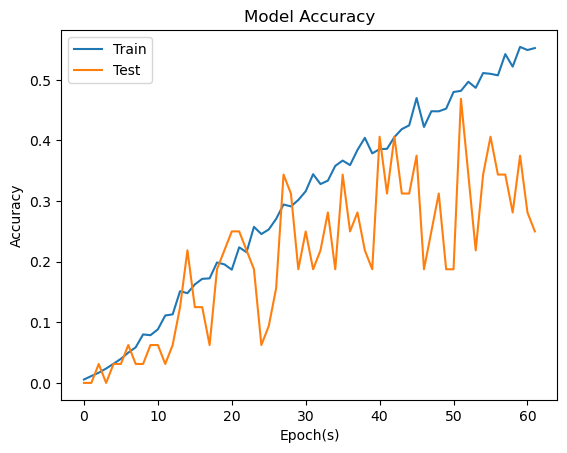

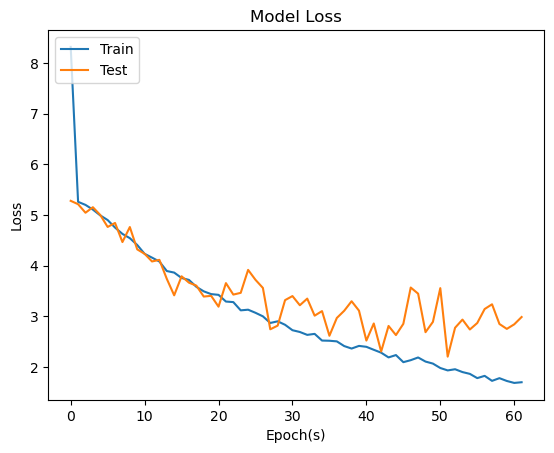

In [7]:
history.history.keys()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch(s)')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch(s)')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [8]:
## this is actually useful
predictions = model.predict(test_generator)

predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
correctly_classified = np.where(predicted_classes == true_classes)[0]
incorrectly_classified = np.where(predicted_classes != true_classes)[0]

print("Correctly Indentified:" , len(correctly_classified))
print("Incorrectly Indentified:" , len(incorrectly_classified))

252/252 [==============================] - 753s 3s/step
Correctly Indentified: 45
Incorrectly Indentified: 7996


In [9]:
model.save("/kaggle/working/")

In [10]:
# class_indices = test_generator.class_indices
# # Invert the class indices
# inv_class_indices = {v: k for k, v in class_indices.items()}
# # Decode the predictions
# decoded_preds = []
# for pred in predictions:
#     # Get the index of the predicted class
#     pred_class_idx = pred.argmax()
    
#     # Map the predicted class index to the corresponding class name
#     pred_class_name = inv_class_indices[pred_class_idx]
    
#     # Append the decoded prediction to the list
#     decoded_preds.append(pred_class_name)

In [11]:
# score = model.evaluate_generator(test_generator)
# score

In [12]:
# image = load_img('/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/test/AM General Hummer SUV 2000/00076.jpg', target_size=(200, 200))
# image

In [13]:
# history.history.keys()
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('Model Accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch(s)')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()
# # summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model Loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch(s)')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

In [14]:
# model.save("/kaggle/working/AugmentedData.h5")